**Import libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from pprint import pprint

In [2]:
df1 = pd.read_csv('df1_final.csv')
df1 = df1.drop(columns=['Unnamed: 0'])

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. BASELINE - Predict BVPC after campaign is over

As a baseline model, I will try to predict BVPC, after the last day of the campaign.

Let's suppose is live for 90 days, I will predict the BVPC for the 91st day.
After predicting the BVPC, I will set a CPA = 15% and calculate the ideal CPC bid for that day.

Take the final result of each campaign.
I will exclude daily performance data and keep only the features that I engineered before.

**DEFINING THE TASK:**
Train a regression model to predict the BVPC for each campaign.

**MOTIVATION:**
This idea of predicting with the final result of the campaign seems pretty basic, and not very challenging for a ML task.

I decided to start with this model simple and obvious task, for 2 reasons:
    1. I believe that a baseline model is a great tool for understanding the data and extracting insights, 
    so I wanted to begin modeling ASAP (specially with the time constraint in mind)
    
    2. I have worked for a DSP (demand-side platform), and a recurrent task was to educate clients 
    (the people that operated the platform). What I mean with this is that usually, clients were very anxious 
    to see a good campaign performance, although, an algorithm needs time and (most importantly) data to 
    optimize. And training this model with lots of data, represents how good a prediction can be.

In [4]:
df1.head()

,hotel_id,locale,city,country,abc_category,stars,rating,direct_cost,other_cost,direct_clicks,...,campaign_id,first_conv_date,first_conv_click,campaign_start,campaign_end,days_till_convert,campaign_duration,other_click_per_campaign,other_bookings_per_campaign,other_booking_value_per_campaign
0,8967,DE,Gotha,Germany,C2,4,8153,144,74,2,...,8967_DE,2019-01-14,111,2019-01-01,2019-03-31,13,89,54,1,171.9
1,8967,DE,Gotha,Germany,C2,4,8153,385,0,5,...,8967_DE,2019-01-14,111,2019-01-01,2019-03-31,13,89,54,1,171.9
2,8967,DE,Gotha,Germany,C2,4,8153,532,0,7,...,8967_DE,2019-01-14,111,2019-01-01,2019-03-31,13,89,54,1,171.9
3,8967,DE,Gotha,Germany,C2,4,8153,576,0,8,...,8967_DE,2019-01-14,111,2019-01-01,2019-03-31,13,89,54,1,171.9
4,8967,DE,Gotha,Germany,C2,4,8153,222,72,3,...,8967_DE,2019-01-14,111,2019-01-01,2019-03-31,13,89,54,1,171.9


# 2 - More Feature Engineering and Data Transformations

## 2.1 - Let's create some extra features to address this problem

Calculate the mean of direct cost

In [5]:
# mean_clicks = df1.groupby(['campaign_id'])['direct_cost_no_out'].mean().reset_index().rename(columns={'direct_cost_no_out':'mean_direct_cost'})
mean_clicks = df1.groupby(['campaign_id'])['direct_cost'].mean().reset_index().rename(columns={'direct_cost':'mean_direct_cost'})

df1 = df1.merge(mean_clicks)

del mean_clicks

Create a feature to summarize the click variance for each campaign

In [6]:
df1['delta_clicks'] = df1.groupby(['campaign_id'])['direct_clicks'].diff().rename(columns={'direct_clicks':'delta_clicks'})

mean_delta_clicks = df1.groupby(['campaign_id'])['delta_clicks'].mean().reset_index().rename(columns={'delta_clicks':'mean_delta_clicks'})

df1 = df1.merge(mean_delta_clicks)

In [7]:
del mean_delta_clicks

Calculate the mean of click

In [8]:
mean_clicks = df1.groupby(['campaign_id'])['direct_clicks'].mean().reset_index().rename(columns={'direct_clicks':'mean_direct_clicks'})

df1 = df1.merge(mean_clicks)

del mean_clicks

## 2.2 - Final data transformations

In [10]:
df1.tail()

,hotel_id,locale,city,country,abc_category,stars,rating,direct_cost,other_cost,direct_clicks,...,campaign_end,days_till_convert,campaign_duration,other_click_per_campaign,other_bookings_per_campaign,other_booking_value_per_campaign,mean_direct_cost,delta_clicks,mean_delta_clicks,mean_direct_clicks
107626,258366,US,Monemvasia,Greece,C2,3,7972,0,0,0,...,2019-03-30,60,87,1,0,0.0,26.938776,0.0,-0.020833,0.183673
107627,258366,US,Monemvasia,Greece,C2,3,7972,0,0,0,...,2019-03-30,60,87,1,0,0.0,26.938776,0.0,-0.020833,0.183673
107628,258366,US,Monemvasia,Greece,C2,3,7972,0,0,0,...,2019-03-30,60,87,1,0,0.0,26.938776,0.0,-0.020833,0.183673
107629,258366,US,Monemvasia,Greece,C2,3,7972,0,0,0,...,2019-03-30,60,87,1,0,0.0,26.938776,0.0,-0.020833,0.183673
107630,258366,US,Monemvasia,Greece,C2,3,7972,0,0,0,...,2019-03-30,60,87,1,0,0.0,26.938776,0.0,-0.020833,0.183673


In [11]:
df1['rating'].describe()

count     107631
unique       729
top         8149
freq         990
Name: rating, dtype: object

**rating**

In [35]:
# set rating to numeric, and those values that are null, I will insert rating = 7401, cause it's the most frequent rating value
df1['rating'] = df1['rating'].apply(lambda x: int(x) if x != '\\N' else 7401)


In [36]:
base_df = df1[['campaign_id', 'locale', 'city', 'country', 
               'abc_category', 'stars','direct_cost_per_campaign',
               'direct_booking_value_per_campaign',
               'direct_clicks_per_campaign', 'bvpc',
               'first_conv_click', 'days_till_convert', 
               'campaign_duration', 'other_click_per_campaign', 
               'other_bookings_per_campaign', 'other_booking_value_per_campaign', 
               'mean_direct_cost', 'mean_delta_clicks','mean_direct_clicks','rating']]

In [37]:
base_df = base_df.drop_duplicates()

**Target distribution**:

 Regression models does not require the prediction variables to be ‘normally distributed’ meaning the model will not break and still produce a true output.

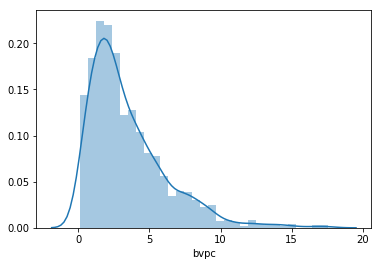

In [38]:
sns.distplot(base_df['bvpc'])

**Correlation with target**:

Surprisingly, the number of clicks does not have a signifcant correlation with the target

In [39]:
train_num = base_df._get_numeric_data()
train_num = base_df.columns

# I will exclude cpc_exp cause this field was calculated using bvpc column
train_num_corr = base_df[train_num].drop(['campaign_id'], axis=1)
corr = pd.DataFrame(train_num_corr.corr(method = 'pearson')['bvpc'])
corr.sort_values(['bvpc'], ascending= False)

,bvpc
bvpc,1.000000
direct_booking_value_per_campaign,0.292359
rating,0.134011
direct_cost_per_campaign,0.034934
other_booking_value_per_campaign,0.034408
mean_direct_cost,0.031890
stars,0.022719
campaign_duration,-0.004593
other_bookings_per_campaign,-0.043382
mean_delta_clicks,-0.047402


## 2.3 - Get dummies and Train/Test Split

In [41]:
dff = base_df.drop(columns=['campaign_id'])

dff = pd.get_dummies(dff, columns=['locale','city','country','abc_category'])

In [42]:
X = dff.drop(columns=['bvpc'])

# Select our target/dependent variable
y = dff['bvpc']

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, random_state=42)

After selecting our target population and applying multiple aggregations, our dataset is not very big.

In [43]:
len(X_train)

827

# 3 - Start Modeling (baseline)

As we were dealing with a small volume dataset, I decided to use regularization methods to avoid overfitting. 

I also used GridSearchCV to find the best parameters for each model.

On both **Ridge and Lasso** regression, many coefficients were set to zero.

## 3.1 - Ridge

In [68]:
# verbose_level=10
from sklearn.model_selection import GridSearchCV

verbose_level=1

regr_ridge = GridSearchCV(Ridge(), cv=5, verbose=verbose_level,
                  param_grid={"alpha": [ 10,1,0.1]})

regr_ridge.fit(X_train, y_train)
y_pred = regr_ridge.predict(X_test)
print(regr_ridge.best_params_);

# model evaluation
print ('ridge absolute error: ', mean_absolute_error(y_test, y_pred))
print ('ridge squared error: ',mean_squared_error(y_test, y_pred))

print(regr_ridge.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'alpha': 1}
ridge absolute error:  1.1986076546616728
ridge squared error:  2.8710430526414163
0.5862089482932248


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished


In [89]:
feature_list = list(X_train.columns)

importances = list(regr_ridge.best_estimator_.coef_)

feature_importances_rd = [[feature, round(importance, 2)] for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances_rd = sorted(feature_importances_rd, key = lambda x: x[1], reverse = True)

feature_importances_rd = pd.DataFrame(feature_importances_rd).rename(columns={0:'feature',1:'coefs_ridge'})

## 3.2 - Lasso

In [73]:
from sklearn.linear_model import Lasso

regr_ls = GridSearchCV(Lasso(), cv=2, verbose=verbose_level,
                  param_grid={"alpha": [1e-15, 0.04, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5]})

regr_ls.fit(X_train, y_train)
y_pred = regr_ls.predict(X_test)
print(regr_ls.best_params_);

# model evaluation
print ('Lasso absolute error: ', mean_absolute_error(y_test, y_pred))
print ('Lasso squared error: ',mean_squared_error(y_test, y_pred))


print(regr_ls.best_score_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:492: Converg

{'alpha': 0.01}
Lasso absolute error:  1.2426145025543829
Lasso squared error:  3.045063524741719
0.5932960093823834


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [87]:
feature_list = list(X_train.columns)

importances = list(regr_ls.best_estimator_.coef_)

feature_importances_ls = [[feature, round(importance, 2)] for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances_ls = sorted(feature_importances_ls, key = lambda x: x[1], reverse = True)

feature_importances_ls = pd.DataFrame(feature_importances_ls).rename(columns={0:'feature',1:'coefs_lasso'})

## 3.3 - Random Forest

In [75]:
from sklearn.ensemble import RandomForestRegressor
regr_rf = GridSearchCV(RandomForestRegressor(), cv=4, verbose=0,
                  param_grid={"max_depth": [2,3,4,5,6,7,8,9]})
#regr_dt = DecisionTreeRegressor(max_depth=2)
regr_rf.fit(X_train, y_train)
y_pred = regr_rf.predict(X_test)
print(regr_rf.best_params_);

# model evaluation
print('Random Forest absolute error: ', mean_absolute_error(y_test, y_pred))
print('Random Forest squared error: ',mean_squared_error(y_test, y_pred))

print(regr_rf.best_score_)

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The de

{'max_depth': 8}
Random Forest absolute error:  0.3988056368272475
Random Forest squared error:  0.5881630467269338
0.9079128882760276


/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
col = [‘SepalLengthCm’ ,’SepalWidthCm’ ,’PetalLengthCm’ ,’PetalWidthCm’]
#modelname.feature_importance_
y = estimator.feature_importances_
#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color=”green”)
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title(‘Feature importance in RandomForest Classifier’)
plt.xlabel(‘Relative importance’)
plt.ylabel(‘feature’) 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [99]:
feature_list = list(X_train.columns)
# Get numerical feature importances
importances = list(regr_rf.best_estimator_.feature_importances_)
#     regr_rf.feature_importances_)
# List of tuples with variable and importance
feature_importances_rf = [[feature, round(importance, 2)] for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances_rf = sorted(feature_importances_rf, key = lambda x: x[1], reverse = True)

In [100]:
feature_importances_rf = pd.DataFrame(feature_importances_rf).rename(columns={0:'feature',1:'feature_imp_randfor'})

In [101]:
feature_importances_rf = feature_importances_rd.merge(feature_importances_rf, on='feature')
feature_importances_rf = feature_importances_ls.merge(feature_importances_rf, on='feature')

In [116]:
feature_importances_rf.sort_values(by='coefs_lasso', ascending=False)[:10]

,feature,coefs_lasso,coefs_ridge,feature_imp_randfor
0,country_Israel,2.37,2.53,0.01
1,locale_US,2.26,2.00,0.03
2,city_Monemvasia,1.71,2.91,0.00
3,locale_UK,1.64,1.61,0.03
4,city_Jerusalem,1.51,2.73,0.00
5,city_Lucca,1.28,2.66,0.00
6,city_Bassano del Grappa,1.23,1.51,0.00
7,city_Verbier,1.23,2.68,0.02
8,city_Athens,1.10,1.92,0.00
9,country_Switzerland,0.85,1.30,0.00


From this table, we can see that the most important feature to Random Forest regression model was direct_booking_value_per_campaign, and the other 2 models zeroed the coefficient for this feature

In [117]:
feature_importances_rf.sort_values(by='feature_imp_randfor', ascending=False)[:10]

,feature,coefs_lasso,coefs_ridge,feature_imp_randfor
21,direct_booking_value_per_campaign,0.00,0.00,0.36
22,direct_clicks_per_campaign,-0.00,0.00,0.23
547,mean_direct_clicks,-0.17,-0.46,0.18
553,locale_IT,-1.22,-1.65,0.03
3,locale_UK,1.64,1.61,0.03
1,locale_US,2.26,2.00,0.03
20,direct_cost_per_campaign,-0.00,-0.00,0.02
7,city_Verbier,1.23,2.68,0.02
539,days_till_convert,-0.01,-0.01,0.01
28,rating,0.00,0.00,0.01


# 4 - Baseline Conclusion

The Random Forest Regressor had the best performance comparing to Ridge and Lasso regression models.

Random Forest can be very time consuming, but as the data sample is not big, I trained it with ease. 

The results of fitting this model proves a benefit of Random Forest, it usually capture the dependencies between features, much better than Linear Regression models like Ridge and Lasso.

As BVPC is calculated by dividind direct_booking_value by direct_clicks, I expected all models to perform much better, since we have the those two information in the dataset. And the table above proves how much better RF will perform, since the relationship sen is not linear.